In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

from pathlib import Path
import os 

C:\Users\Brand\AppData\Local\Temp\ipykernel_25032\2951499837.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
obesity_data_path = Path(r"C:\Users\Brand\project_env\SciKit-Data Science\data\Multi-Class Prediction of Obesity Risk")
train_data_path = obesity_data_path / "train.csv"
test_data_path = obesity_data_path / "test.csv"

train_data = pd.read_csv(train_data_path, index_col=0)
test_data = pd.read_csv(test_data_path, index_col=0)


In [3]:
train_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
train_data.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [5]:
train_data.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [6]:
categorical_data = train_data.select_dtypes("object").drop(columns=["NObeyesdad"])
y = train_data["NObeyesdad"]

In [7]:
numeric_data = train_data.select_dtypes("float64")

In [8]:
train_data.duplicated().sum()

0

In [9]:
categorical_data.head(10)

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
id,,,,,,,,
0,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
1,Female,yes,yes,Frequently,no,no,no,Automobile
2,Female,yes,yes,Sometimes,no,no,no,Public_Transportation
3,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
4,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
5,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
6,Male,yes,yes,Sometimes,no,no,Sometimes,Automobile
7,Male,yes,yes,Sometimes,no,no,Sometimes,Automobile
8,Male,no,yes,Sometimes,no,yes,no,Public_Transportation


In [10]:
def cardinalitity(object_df:pd.DataFrame):
    return pd.Series({col: len(object_df[col].unique()) for col in object_df.columns})

cardinalitity_series = cardinalitity(categorical_data)

low_card_cols = [index for index in cardinalitity_series.index if cardinalitity_series[index] < 3]
high_card_cols = list(cardinalitity_series.drop(index=low_card_cols).index)
high_card_cols

['CAEC', 'CALC', 'MTRANS']

C:\Users\Brand\AppData\Local\Temp\ipykernel_25032\2548763989.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cardinalitity_series.sort_values(ascending=True), palette=sns.color_palette("rocket"))
C:\Users\Brand\AppData\Local\Temp\ipykernel_25032\2548763989.py:3: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=cardinalitity_series.sort_values(ascending=True), palette=sns.color_palette("rocket"))


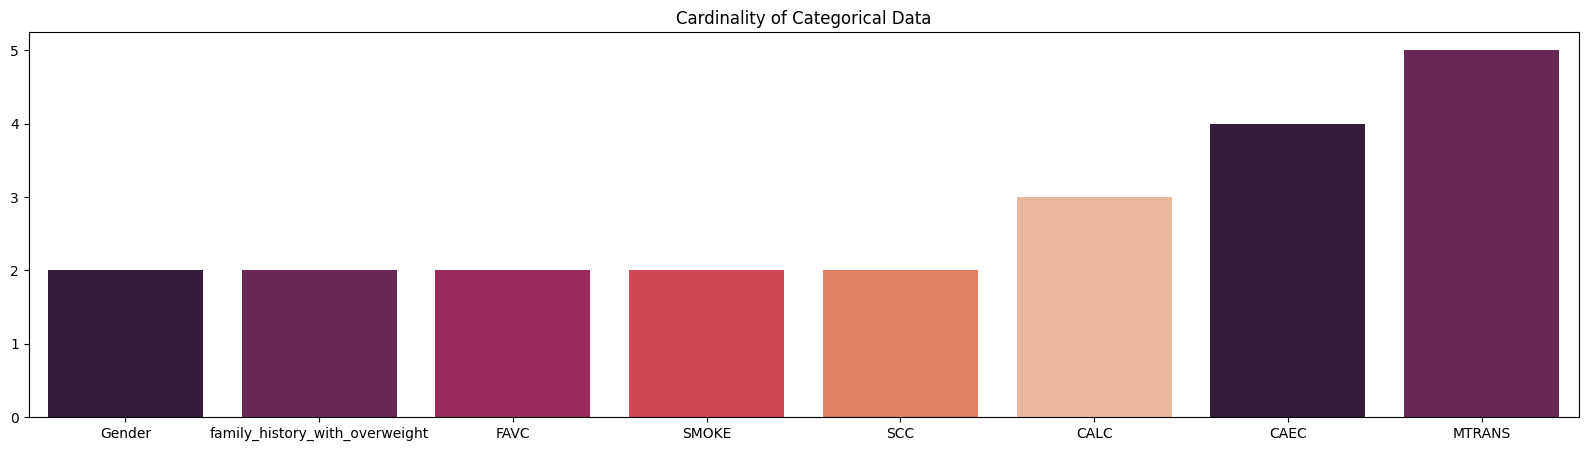

In [11]:
plt.figure(figsize=(20,5))
plt.title("Cardinality of Categorical Data")
sns.barplot(data=cardinalitity_series.sort_values(ascending=True), palette=sns.color_palette("rocket"))
plt.show()

In [12]:
def encoding(object_df:pd.DataFrame, threshold:int):
    label_encoder = LabelEncoder()
    
    low_card_col =[col for col in object_df.columns if len(object_df[col].unique()) < threshold]
    label_encoded_df = object_df[low_card_col].apply(label_encoder.fit_transform)
    one_hot_encoded_df = pd.get_dummies(object_df.drop(columns=low_card_col), dtype="int")
    
    return pd.concat([label_encoded_df, one_hot_encoded_df], axis=1)

encoded_categorical_data = encoding(categorical_data, 3)
encoded_categorical_data.head(10)

,Gender,family_history_with_overweight,FAVC,SMOKE,SCC,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
id,,,,,,,,,,,,,,,,,
0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0
2,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
3,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
4,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
5,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
6,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0
7,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0
8,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0


In [13]:
numeric_data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [14]:
def normalize(numeric_df:pd.DataFrame):
    standard_scaler = StandardScaler()
    numeric_col = numeric_df.columns
    return pd.DataFrame(standard_scaler.fit_transform(numeric_df), columns=numeric_col)
    
normalized_numeric_data = normalize(numeric_data)

In [15]:
X = pd.concat([normalized_numeric_data, encoded_categorical_data], axis=1)
y = LabelEncoder().fit_transform(y)

<Axes: >

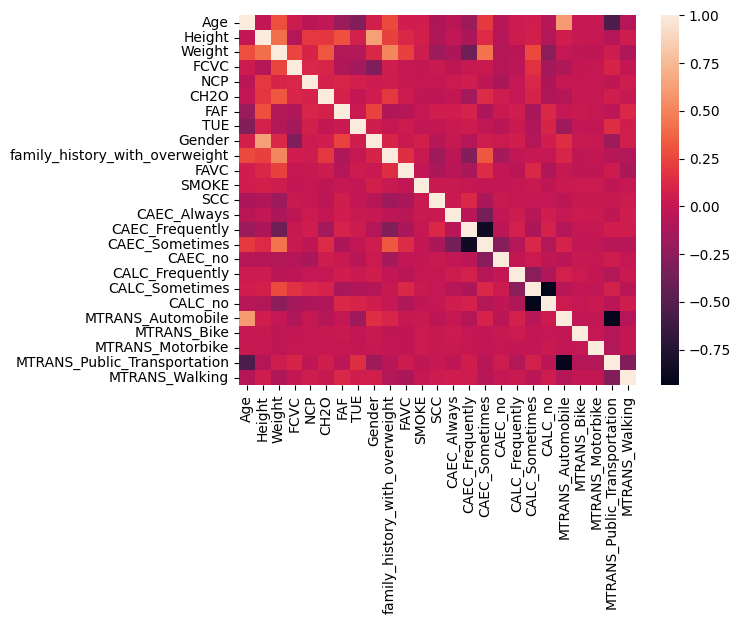

In [16]:
sns.heatmap(X.corr())

<Axes: xlabel='Gender', ylabel='Age'>

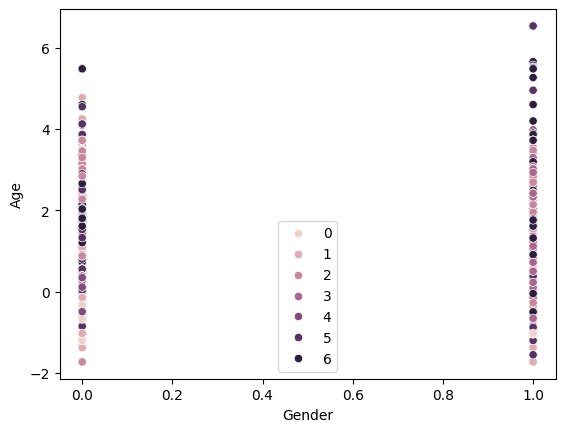

In [18]:
X.sort_values(by=["Age"], ascending=False)
sns.scatterplot(data=X, x="Gender", y="Age", hue=y)

C:\Users\Brand\AppData\Local\Temp\ipykernel_25032\2889155826.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pd.Series(mutual_info_classif(X,y), index=X.columns).sort_values(ascending=False), orient="h", palette="RdBu")


<Axes: title={'center': 'Feature Importance Using Mutual Information'}>

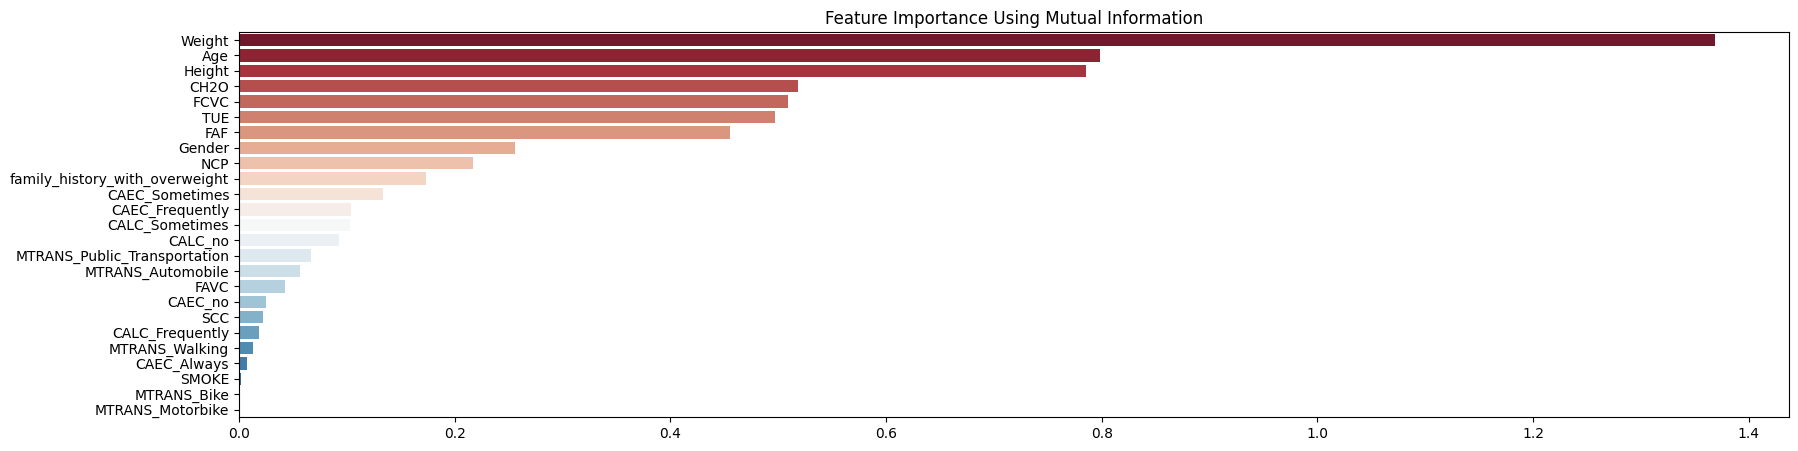

In [23]:
# feature selection
plt.figure(figsize=(20,5))
plt.title("Feature Importance Using Mutual Information")
sns.barplot(pd.Series(mutual_info_classif(X,y), index=X.columns).sort_values(ascending=False), orient="h", palette="RdBu")

In [27]:
# Implementation of Sklearn Pipelines and ColumnTransformers
cat_col_preprocess = ColumnTransformer(
    [("high_cardinality_cat", OneHotEncoder(), high_card_cols),
     ("low_cardinality_cat", OrdinalEncoder(), low_card_cols),
     ("numeric_value", StandardScaler(), numeric_data.columns)],
    remainder="passthrough")

cleaned_train_data = pd.DataFrame(cat_col_preprocess.fit_transform(train_data, y))
cleaned_test_data = pd.DataFrame(cat_col_preprocess.fit_transform(test_data, y))

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.508163,1.682789,1.273786,0.932524,0.350808,1.298389,-0.141769,-1.005016
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.509128,-1.114658,-0.818988,-0.833161,-2.462523,1.583678,0.030307,-1.005016
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.353000,-0.626191,0.927432,1.047997,0.350808,0.965029,-1.159701,-0.592995
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.512705,-1.642760,0.623672,-0.833161,0.319733,1.234234,-1.046828,-1.005016
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.353000,-0.805996,0.668336,1.047997,0.350808,1.016818,-1.159701,0.213881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.107749,0.252936,-0.358246,0.696661,0.350808,-1.688533,-0.199274,0.275664
13836,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.870277,-1.227324,-0.972181,1.047997,0.350808,-0.052428,-1.159701,-1.005016
13837,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.175379,-1.277495,-1.647125,1.047997,-0.670797,-0.052428,1.160623,0.639766
13838,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-0.509128,-0.889324,-1.316865,-0.833161,0.350808,-0.052428,2.410322,2.284548


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, mean_squared_error, roc_auc_score, precision_score, recall_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix, auc
